# Understanding Etsy Reorders

Authors: Carlo Colizzi, Andrew Kurtz

# Introduction

Andrew has been running a stationery and greeting card business on Etsy for the past 4 years.
During this time, he was able to fulfill thousands of orders, and now would like to understand
what pushes customers to order again, in an attempt to increase customer retention.

We will try to do this by analyzing the order data obtained through the Etsy API, looking specifically
at how often and when customers reorder, as well as the general characteristics of those orders (order size, etc...).

Acquiring new customers is time-consuming and expensive. Therefore, figuring out how to what drives
customer loyalty and improving that would be an easy path for growth. For example, if many customers
reorder for specific occasions as gifts (graduation, Christmas, etc), then sending out targeted
marketing to past customers around those events would be an efficient way to retain customers.

To make sure the code runs correctly, run the cell below:

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from api_lib import get_all_orders, get_all_reviews, read_json, extract_data
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
import pandas as pd
import statistics
from datetime import datetime

# Methodology
## Obtaining the Data

To access the data we requested access to the Etsy API to get an initial access key and credentials from Etsy, then went through the authentication steps to connect it to Andrew's Etsy shop to get updated keys that enable access the private order and review data from the shop.

Using those keys we wrote a python library in the file `api_lib.py` to pull all of the orders and reviews and save them as JSONs. For each order, the API gives us all relavant details including user ID information, shipping detials, all the items in order, total value, and date/time placed. In our analysis only need a fraction of the data. These are the key data points we use from orders:

- `buyer_user_id`: Integer thats a unique identifying id used to keep track of buyers to determine repeat customers
- `create_timestamp`: Unix timestamp for when order was created
- `state`: String with state name abbreviation from shipping address
- `subtotal`: Dictionery with keys:
    - `amount`: Order subtotal amount as int
    - `divisor`: Int representing what value to divide `amount` by to get dollar amount

From the reviews dataset, we only accessed the `buyer_user_id` value which represents the same thing as `buyer_user_id` in the order dataset.

To pull the data and save it locally, we ran the cell below with two functions from our api_lib.py library. We only needed to run this at the beginning and after a few days has passed to update the data with the latest orders. By saving it locally, we can mitigate calls to the API.

In [3]:
KEY_PATH = "keys.json"
ORDERS_PATH = "orders.json"
REVIEWS_PATH = "reviews.json"
SHOP_ID = 23574688

get_all_orders(KEY_PATH, ORDERS_PATH, SHOP_ID)
get_all_reviews(KEY_PATH, REVIEWS_PATH, SHOP_ID)

This cell is used to read the locally stored order and review data, storing them in their respective variables as lists of dictionaries.

In [4]:
orders = read_json('orders.json')
reviews = read_json('reviews.json')

To pull the specific data points mentioned above, we wrote a function called 'extract_data' which extracts the data from all orders stored in parameter_1 and optionally parameter_2 and returns a list. This function will be used throughout the essay.

## Processeing the data
### Number of customers who reorder
In the first step of our analysis, we decided to understand the split between one-off customers and returning customers. We did this by taking all customer ids from all orders, stored in `buyer_user_id`, and using a `Counter()` function to check which ones appear multiple times. You can notice one customer id has been removed. This is because that account in particular was an account used to place test orders, and therefore would skew the data. Once we knew how many orders were repeat orders, and how many were one-off, we were able to represent this on a pie chart.

In [5]:
buyer_user_id = extract_data(orders, "buyer_user_id")

num_orders_by_customers = list(Counter(buyer_user_id).values())

num_orders_by_customers.remove(37)

orders_per_customer = Counter(num_orders_by_customers)

num_reorders = orders_per_customer.keys()
num_customers = orders_per_customer.values()

### Order size

In [6]:
id_subtotal_dict = extract_data(orders, 'buyer_user_id', 'subtotal')
num_orders_by_id = Counter(buyer_user_id)

id_subtotal = []
for customer in id_subtotal_dict:
    id_subtotal.append([customer[0], customer[1]['amount']/customer[1]['divisor']])

single_order_customers = []
multiple_order_customers = []

for customer in id_subtotal:
    if num_orders_by_id[customer[0]] > 1:
        multiple_order_customers.append(customer[1])
    else:
        single_order_customers.append(customer[1])

single_order_value = statistics.mean(single_order_customers)
multiple_order_value = statistics.mean(multiple_order_customers)

### Time between reorders

In [7]:
order_time = extract_data(orders, 'create_timestamp')

for i in range(len(order_time)):
    order_time[i] = datetime.fromtimestamp(order_time[i])

orders_by_customer = {}

for customer_id, order_time in zip(buyer_user_id, order_time):
    if customer_id not in orders_by_customer:
        orders_by_customer[customer_id] = []
    orders_by_customer[customer_id].append(order_time)

all_time_diffs = []

for times in orders_by_customer.values():
    times.sort() 
    if len(times) > 1:
        all_time_diffs.extend([times[i] - times[i-1] for i in range(1, len(times))])

years = [t.days / 365.25 for t in all_time_diffs]

### Dates of Reorders

In [8]:
mult_cust_times = {}
single_cust_times = {}

for id, dates in orders_by_customer.items():
    if len(dates) > 1:
        mult_cust_times[id] = dates
    else:
        single_cust_times[id] = dates

single_by_month = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
multiple_by_month = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for id, dates in mult_cust_times.items():
    for datetime in dates:
        month = datetime.month
        multiple_by_month[month - 1] += 1

for id, dates in single_cust_times.items():
    single_by_month[dates[0].month - 1] += 1

### Number of orders by state

In [9]:
state = extract_data(orders, 'state')

state_list = Counter(state)
state_list = pd.DataFrame.from_dict(state_list, orient='index').reset_index()
state_list = state_list.rename(columns={"index":"state", 0:"number_of_orders"})

### Repeat order rate by state

In [10]:
id_state = extract_data(orders, 'buyer_user_id', 'state')
state = extract_data(orders, 'state')

all_states_list = list(Counter(state).keys())
states_dict = {key: [] for key in all_states_list}

for customer in id_state:
    states_dict[customer[1]].append(customer[0])

percent_reorder_by_state = {}
for state, ids in states_dict.items():
    num_orders = Counter(Counter(states_dict[state]).values())
    one_order = 0
    multiple_orders = 0
    for number_of_orders, number_of_customers in num_orders.items():
        if number_of_orders == 1:
            one_order += number_of_customers
        if number_of_orders > 1:
            multiple_orders += number_of_customers
    if one_order + multiple_orders > 20:
        percent_reorder_by_state[state] = multiple_orders / (one_order + multiple_orders)

state_reorder_df = pd.DataFrame.from_dict(percent_reorder_by_state, orient='index').reset_index()
state_reorder_df = state_reorder_df.rename(columns={"index":"state", 0:"reorder_rate"})

### Reviews

In [11]:
review_ids = extract_data(reviews, 'buyer_user_id')
num_orders_by_id = Counter(buyer_user_id)
num_reviews_by_id = Counter(review_ids)
left_review = list(num_reviews_by_id.keys())

count_reorders = 0
for id in left_review:
    if num_orders_by_id[id] > 1:
        count_reorders+=1

repeat_percent_yes_review = count_reorders/len(left_review)

count_reorders = 0
for id in list(num_orders_by_id.keys()):
    if num_orders_by_id[id] > 1:
        count_reorders+=1

repeat_percent_overall = count_reorders/len(list(num_orders_by_id.keys()))

count_reorders = 0
count_not_review = 0

for id in list(num_orders_by_id.keys()):
    if id not in left_review:
        count_not_review += 1
        if num_orders_by_id[id] > 1:
            count_reorders+=1

repeat_percent_no_review = count_reorders/count_not_review

# Results

## Visualizing Data

***
Answer these questions for each visualization 

What summaries or visualizations did you create?

What are the interesting and/or important parts of these summaries or visualizations?

How do these results answer your questions or tell your story?

***

### Understanding the number of customers that reorder
For our first visualization we wanted to see the distribution of how the number of orders customers place to gain a general understanding of the repeat order rate. This will also help give context to the rest of the essay of how many customers are in the category of repeat customers.


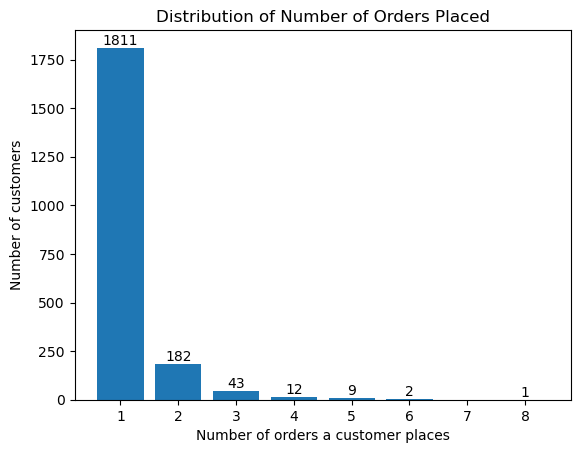

In [12]:
labels = [str(item) for item in list(num_customers)]

fig, ax = plt.subplots()
bars = ax.bar(num_reorders, num_customers, label=labels)

# Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.xlabel("Number of orders a customer places")
plt.ylabel("Number of customers")
plt.title("Distribution of Number of Orders Placed")

plt.show()

This visualization shows that the vast majority of customers are single order, a few place two orders, fewer place three, and so on. There are many factors from a business and branding perspective that could account for the low repeat customer rate. The first is that customers are unsatisfied with the product, but that is unlikely because 590 of the 600 reviews are five stars. Another potential factor is that customers aren't attached to my brand specifically, but rather the platform Etsy as a whole. This would mean that when they want to order more stationery, they won't go to Andrew's Etsy shop specifically, but rather search the whole platform and ultimetely order from a different shop.

While the majority of customers don't repeat, there is a group of loyal customers who repeat order many times. This is seen in the data by 43 customers who order 3 times, 12 who order 4 times, 9 who order 5 times, and a few who have ordered even more than that. This suggests that brand loyalty does exist, but at low rates and through increased branding it is possible to grow these numbers more.

### Order Size

With a general understanding of how many customers reorder, we wanted to better understand if there was a difference in size of customers who reorder vs not. For example, maybe repeat customers tend to place more smaller orders. These results could influence the value of trying to attract more repeat customers because if they place small orders on average our time may be more effectively spent attracting new higher value customers.

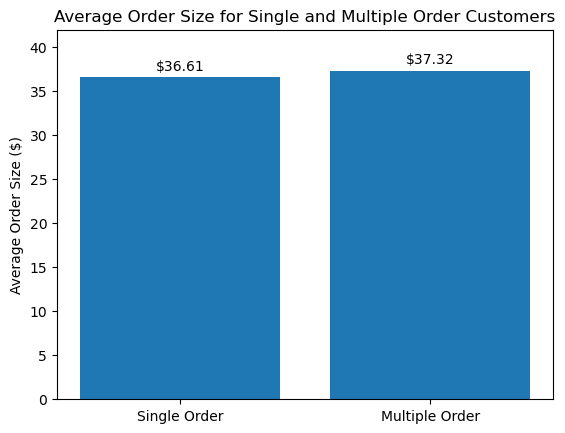

In [19]:
fig, ax = plt.subplots()

labels = ["Single Order", "Multiple Order"]
amounts = [single_order_value, multiple_order_value]

bars = ax.bar(range(len(labels)), amounts, align='center')
ax.set_xticks(range(len(labels)), labels=labels)
ax.bar_label(bars, padding=3, label_type='edge', fmt='$%.2f')
ax.set_ylabel('Average Order Size ($)')
ax.set_title('Average Order Size for Single and Multiple Order Customers')
ax.set_ylim(0, 42)

plt.show()

From this plot we can see that multiple order customers place marginally higher orders on average, but it isn't statistically significant. This is interesting because it disproves the theory that Andrew has seen anecdotally that repeat customers tend to place smaller orders. This means that it is worth trying to increase the repeat order rate becuase they are just as valuable as one offs. 

### Time between re-orders

Another characteristic of repeat customers that we wanted to observe was the time difference between repeat orders. Do people typically wait to run out or reorder or reorder right away? Finding this out could help us inform the decision on how long after they order to market to past customers. We decided to visualize this as a Violin plot so that we could see the trends of the density of repeat orders with each spacing in a continuous manner without needing to choose bins for a histogram.

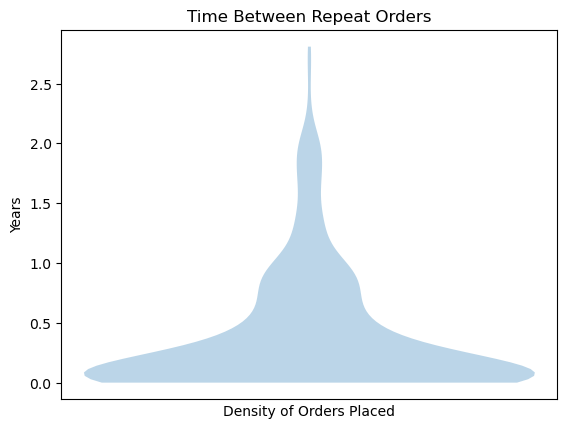

In [23]:
plt.violinplot(years, showmeans=False, showmedians=False,showextrema=False)
plt.ylabel('Years')
plt.xlabel('Density of Orders Placed')
plt.title('Time Between Repeat Orders')
plt.xticks([])
plt.show()

The plot shows that most of the repeat orders take place within a few months of the previous order, but there is also a bump around 9-12 months and two years. This suggests that the most effective marketing would be done at those increments after the first order is placed. This way it wouldn't be necessary to spam a customer because we have the data for precision targeted marketing.

### Understanding the dates of reorders

Since we noticed a bump at around 1 and 2 years we wondered what could possibly cause this. One answer that came to mind fairly quickly was holidays and birthdays. To unpack the data further to answer this question we thus decided to look at the distribution of orders from single order and repeat order customers based on time of year. This way we could see trends around holidays.

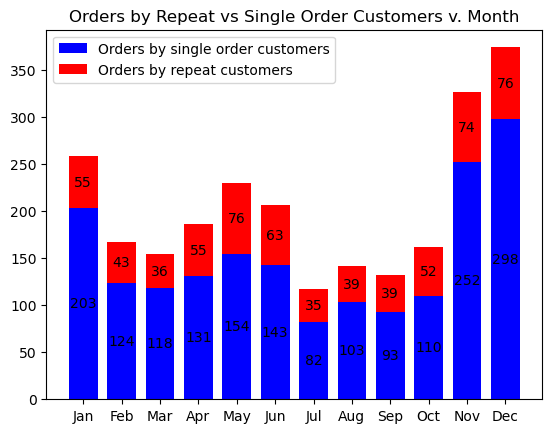

In [15]:
months_abbreviations = [
    "Jan", "Feb", "Mar", 
    "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", 
    "Oct", "Nov", "Dec"
]

fig, ax = plt.subplots()
bottom = 12

width = .75

for index in range(12):
    p = ax.bar(months_abbreviations[index], single_by_month[index], width, bottom=0, color='blue')
    q = ax.bar(months_abbreviations[index], multiple_by_month[index], width, bottom=single_by_month[index], color='red')

    ax.bar_label(p, label_type='center')
    ax.bar_label(q, label_type='center')

ax.set_title('Orders by Repeat vs Single Order Customers v. Month')
ax.legend(['Orders by single order customers', 'Orders by repeat customers'])

plt.show()

Looking at the data there are a few key trends to take stock of. The first is that repeat customers tend to place the most orders in May and June and November and December. This confirms our hypothesis that customers place the most repeat orders around holidays/occasions. In May/June one of the main reasons to order personalized stationery is graduation gifts/thank you notes and November/December is of course Christmas gifts. This can help further inform marketing to suggest increase efforts in graduation season and the holidays.

Another trend to note is that there is a significant number of single order customers that order around the holidays. Combining this finding with the finding of the previous graph that many repeat customers order within a few months after their previous order means that an effective strategy to turn these buyers into repeat customers would be increasing marketing targeting these first time customers in January, February, and March.

### Orders per state

Analyzing the time orders occurred at made us curious about exploring where these orders were occurring and if certain parts of the country had a higher repeat order rate. Using the data pulled using the Etsy API, we plotted the shipping addresses to see what countries were most common. However, we quickly realised all but 3 orders occurred within the USA. Thus, we decided to narrow down our search, to plot what states orders came from. 

We first started by plotting the number of orders shipped to each state to get a broad geographic understanding before focusing on repeat customers.

In [16]:
fig = px.choropleth(state_list, locationmode = 'USA-states', locations='state', color='number_of_orders',
                        color_continuous_scale="Greens",
                        range_color=(0, 150),
                        scope="usa",
                        labels={'number_of_orders':'Number of Orders'},
                        )
fig.update_layout(title_text = 'Etsy Orders by State', geo_scope='usa', margin={"r":20,"t":80,"l":0,"b":30})
fig.show()

### Repeat order rate by state
With the geographic distribution of the orders in mind, we created a map of the percent repeat customers in each state. To ensure the data shown was statistically significant, we filtered out the states with fewer than 20 customers. This prevents cases where a state may only have a few customers, so if one of them reorders the reorder rate is articially high. 

In [17]:
fig = px.choropleth(state_reorder_df, locationmode = 'USA-states', locations='state', color='reorder_rate',
                        color_continuous_scale="Greens",
                        range_color=(0, .2),
                        scope="usa",
                        labels={'reorder_rate':'Percent Repeat Customers by State'},
                        )
fig.update_layout(title_text = 'Percent Repeat Customers by State', geo_scope='usa', margin={"r":20,"t":80,"l":0,"b":30})
fig.show()

### Reviews
We were also curious if people who leave a review are more likely to reorder than people who don't. To find ths out we:

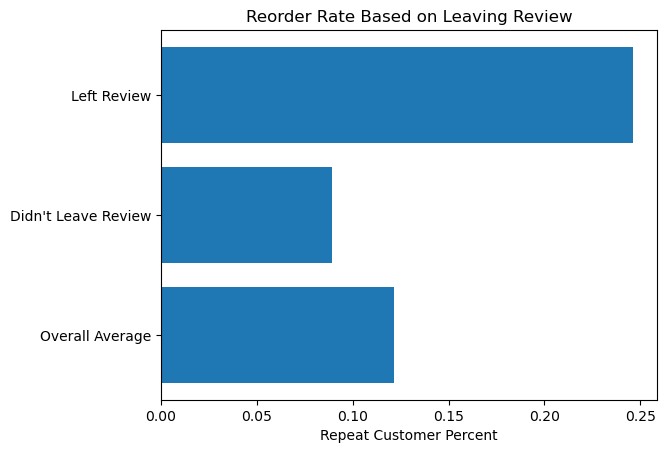

In [18]:
fig, ax = plt.subplots()

labels = ["Left Review", "Didn't Leave Review", "Overall Average"]
percents = [repeat_percent_yes_review, repeat_percent_no_review, repeat_percent_overall]

ax.barh(range(len(labels)), percents, align='center')
ax.set_yticks(range(len(labels)), labels=labels)
ax.invert_yaxis()
ax.set_xlabel('Repeat Customer Percent')
ax.set_title('Reorder Rate Based on Leaving Review')

plt.show()

### How we're going to act on this

## Concluding remarks

What are the important insights that the reader should get from this project?

What are the ethical considerations surrounding the data sourcing?
What are the contextual or ethical implications of your topic or work?

For the most part, this project creates no ethical concerns. However, it is important to notice that some sensitive data is used for the geographical analysis, such as zipcodes. While zipcodes per se are not someting that can identify a specific person, they can be used along with other data to do so. Furthermore, while we chose not to use the full address of people, it is also important to notice that the API does provide this data if requested. Therefore, there is a potential for misuse of this sensitive data.

What lessons did you learn as you did the project?

What were the most difficult, challenging, or frustrating parts of the project?

One of the most frustrating parts of the project was creating the interactive map graphs. This is because they were created using a library that neither of us have used before, and therefore knew nothing about. Furthermore, another challenging part of this project was obtaining the API data. API calls were new for both of us, and the specific syntax and error codes were difficult to understand at first. This is why we initially thought of using a separate library to write the API calls, but abandoned this idea to maintain the overall structure of the project simpler. 

### Assumptions and Future Improvements
In what ways would you extend or change your project if you had more time?

If we had more time, we believe it would be useful to dive deeper into the psychology of the customer, understanding exactly what elements drive a customer to reorder. It could also be very interesting to assess the success of different customer retention techniques, such as newsletters, promo codes, sales, bundles, or else. 